# Football Analysis:

# Do red cards seem to lead to more goals?

In [1]:
# !pip install matplotlib
# !pip install scikit-learn
# !pip install jinja2
# !pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1. What data are we working with?

In [3]:
# read in our data
df_g = pd.read_csv('data/games.csv')
df_e = pd.read_csv('data/events.csv')

In [4]:
df_e.sort_values(by='game_id')

,game_id,minute,side,type
0,1,69,home,red_card
4132,1,90,away,goal
4131,1,23,away,goal
4133,2,86,home,goal
4134,2,48,away,goal
...,...,...,...,...
54449,19293,6,away,goal
4130,19293,89,away,red_card
54447,19293,43,home,goal
54448,19293,90,home,goal


In [5]:
# Get the range of dates for each competition
date_range_per_competition = df_g.groupby('competition')['date'].agg(['min', 'max'])

print(date_range_per_competition)

                                min         max
competition                                    
1. Bundesliga, Germany   2018-08-24  2023-05-27
2. Bundesliga, Germany   2018-08-03  2023-05-28
Championship, England    2018-08-03  2023-05-08
Ligue 1, France          2018-08-10  2023-06-03
Ligue 2, France          2018-07-27  2023-06-02
Premier League, England  2018-08-10  2023-05-28
Primera, Spain           2018-08-17  2023-06-04
Segunda, Spain           2018-08-17  2023-05-28
Serie A, Italy           2018-08-18  2023-06-04
Serie B, Italy           2018-08-24  2023-05-19


In [6]:
print("Matches in games.csv data set: ",len(df_g))
# Sum of home and away goals in df_g
total_goals_df_g = df_g['home_goals'].sum() + df_g['away_goals'].sum()
print("Goals in games.csv data set: ",total_goals_df_g)
print("Goals in events.csv data set: ",len(df_e[df_e['type']=='goal']))
print("Red Cards in events.csv data set: ",len(df_e[df_e['type']=='red_card']))

Matches in games.csv data set:  19294
Goals in games.csv data set:  50356
Goals in events.csv data set:  50320
Red Cards in events.csv data set:  4131


## 2. Data Cleaning:

### 2.a: Discrepancies between the two dataframes.
There is a discrepancy in the data frames as you can see above. 36 more goals in the games.csv than in the events.csv.

Since we are missing the goal times of these discrepancies, we don't have the full data to impute the missing values. There was one red card in the 26 games with missing information. We will exclude these from our analysis. This list should be reported to data collectors for investigation.

In [7]:
# Create a new dataframe with the total number of goals per game in df_g
df_g_goals = df_g.groupby('game_id').apply(lambda row: row['home_goals'] + row['away_goals'], include_groups=False).reset_index(name='goals')

# Create a new dataframe with the total number of 'goal' events per game in df_e
df_e_goals = df_e[df_e['type'] == 'goal'].groupby('game_id').size().reset_index(name='goals')

# Merge the two dataframes on 'game_id'
df_goals = pd.merge(df_g_goals, df_e_goals, on='game_id', suffixes=('_df_g', '_df_e'), how='outer')

#fill the empty rows with 0 as no goals were recorded for this
df_goals['goals_df_e'] = df_goals['goals_df_e'].fillna(0)

# Find the rows where the number of goals doesn't match
discrepancies = df_goals[df_goals['goals_df_g'] != df_goals['goals_df_e']]

print("There are", len(discrepancies), "games with a differing number of goals")

There are 26 games with a differing number of goals


In [8]:
# Filter the rows in df_g where 'game_id' is in the list of game ids with discrepancies
wrong_scores_df_g = df_g[df_g['game_id'].isin(discrepancies['game_id'])]

# print(wrong_scores_df_g)

from tabulate import tabulate

# Print the DataFrame using tabulate
print(tabulate(wrong_scores_df_g, headers='keys', tablefmt='psql', showindex=False))


+-----------+------------------------+---------------------+-----------------------+------------+--------------+--------------+
|   game_id | home_team              | away_team           | competition           | date       |   home_goals |   away_goals |
|-----------+------------------------+---------------------+-----------------------+------------+--------------+--------------|
|       321 | Cosenza                | Hellas Verona       | Serie B, Italy        | 2018-09-01 |            0 |            3 |
|      2181 | Albacete               | Reus Deportiu       | Segunda, Spain        | 2019-01-27 |            1 |            0 |
|      2304 | Reus Deportiu          | Elche               | Segunda, Spain        | 2019-02-03 |            0 |            1 |
|      2383 | Gimnastic de Tarragona | Reus Deportiu       | Segunda, Spain        | 2019-02-09 |            1 |            0 |
|      2512 | Reus Deportiu          | Almería             | Segunda, Spain        | 2019-02-17 |       

In [9]:
# Filter the rows in df_e where 'game_id' is in the list of game ids with discrepancies
wrong_scores_df_e = df_e[df_e['game_id'].isin(discrepancies['game_id'])]

print(wrong_scores_df_e)

      game_id  minute  side      type
1747     7876      63  away  red_card


In [10]:
df_g_clean = df_g[~df_g['game_id'].isin(discrepancies['game_id'])]
df_e_clean = df_e[~df_e['game_id'].isin(discrepancies['game_id'])]

### 2.b: Missing values - None.

In [11]:
print(df_g_clean.isnull().sum())
print(df_e_clean.isnull().sum())

game_id        0
home_team      0
away_team      0
competition    0
date           0
home_goals     0
away_goals     0
dtype: int64
game_id    0
minute     0
side       0
type       0
dtype: int64


### 2.c: Duplicate Rows 

There are 160 duplicate rows in the events.csv, as games that had 2 or more events in injury time (beyond 45 or 90 minutes) were stored as 45 or 90 in the events.csv file. These duplicates simply mean two or more events occurred in the same time period.

However there are 3 instances of mid-game duplicates (at 32, 55 and 84 minutes). In these cases, there were two red cards at the same time. (These games can be found in duplicates_in_df_g). Interestingly, two of these double red cards happened on the same day in April, 2022.

In [12]:
print('Duplicate rows in games.csv:', df_g_clean.duplicated().sum())
print('Duplicate rows in events.csv:', df_e_clean.duplicated().sum())

Duplicate rows in games.csv: 0
Duplicate rows in events.csv: 160


In [13]:
# Get both original and duplicated rows based on 'game_id'
duplicates = df_e_clean[df_e_clean.duplicated(keep=False)].sort_values(by='game_id')

print('List of duplicated events:')
print(duplicates.head())

print('Minutes with two or more events:')
print(duplicates.minute.unique())

List of duplicated events:
      game_id  minute  side  type
4735      243      90  home  goal
4736      243      90  home  goal
5701      603      90  home  goal
5700      603      90  home  goal
5704      605      90  away  goal
Minutes with two or more events:
[90 45 32 55 84]


In [14]:
# Filter the rows in duplicates where 'minute' is 32, 55, or 84
duplicates_filtered = duplicates[duplicates['minute'].isin([32, 55, 84])]

# Filter the rows in df_g_clean where 'game_id' is in the 'game_id' column of duplicates_filtered
duplicates_in_df_g = df_g_clean[df_g_clean['game_id'].isin(duplicates_filtered['game_id'])]
print(duplicates_filtered)

      game_id  minute  side      type
1350     6157      32  away  red_card
1351     6157      32  away  red_card
3159    14807      55  home  red_card
3158    14807      55  home  red_card
3161    14817      84  away  red_card
3160    14817      84  away  red_card


### 2.d Outliers:

The number of goals in each game per team is standard for football, with mostly low scores between [0,3] and occasional high scores up to 9.

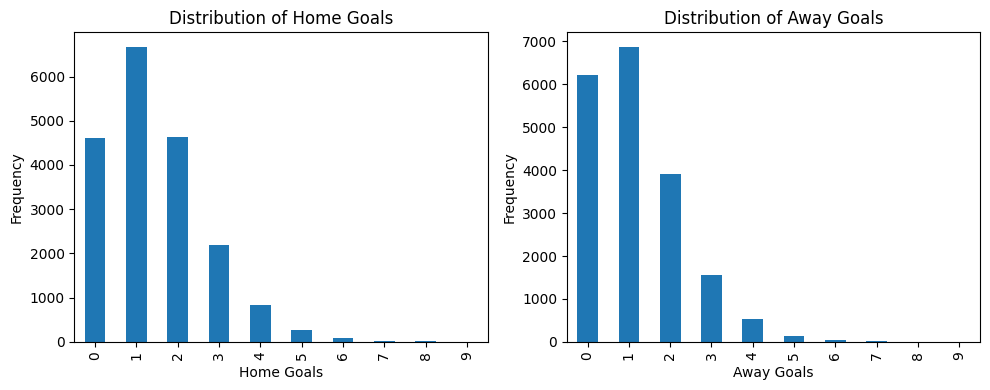

In [15]:
# Plot a bar plot for 'home_goals'
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df_g['home_goals'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Home Goals')
plt.xlabel('Home Goals')
plt.ylabel('Frequency')

# Plot a bar plot for 'away_goals'
plt.subplot(1, 2, 2)
df_g['away_goals'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Away Goals')
plt.xlabel('Away Goals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### 2.e Merge Data

In [16]:
# Left merge to create df with all games, and their events (even when none occurred)
df = pd.merge(df_g_clean, df_e_clean, on='game_id', how='left')

## 3. Do Red Cards seem to lead to more goals?

### 3.a Simple Correlation:

A simple correlation of goals and red cards gives a very weak negatived correlation. 

The correlation plot shows that many combinations of red cards and goals can occur, although interestingly there has never been a game with neither a goal or a red card in these leagues in the last 5 years. 

The density plot below, however, shows that 0 red cards and low scoring games are much more common and account for the vast majority of our data.

But of course, we need to account for when the red card occured in the game. We need to account for proportionality.

In [17]:
# Add a new column for the total number of goals in a game
df['total_goals'] = df['home_goals'] + df['away_goals']

# Add a new column for whether the event is a red card
df['is_red_card'] = df['type'].apply(lambda x: 1 if x == 'red_card' else 0)

# Calculate the total number of red cards per game
df['red_cards'] = df.groupby('game_id')['is_red_card'].transform('sum')

# Sort the DataFrame so events are in order
df = df.sort_values(['game_id', 'minute'])

# Calculate the correlation
correlation = df['total_goals'].corr(df['red_cards'])
print("Correlation of goals to red cards",correlation)

Correlation of goals to red cards -0.04279847057843651


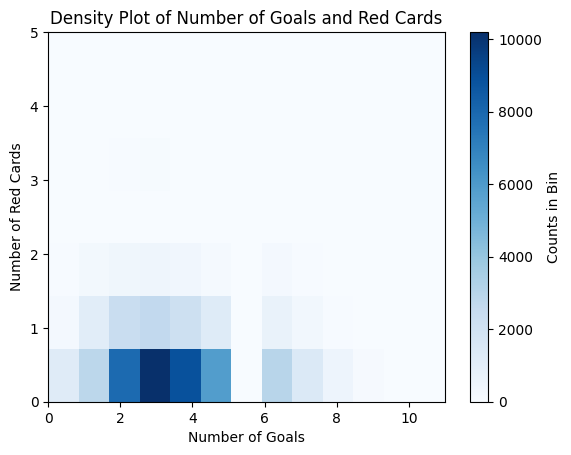

In [18]:
plt.hist2d(df['total_goals'], df['red_cards'], bins=[13, 7], cmap='Blues')
cb = plt.colorbar()
cb.set_label('Counts in Bin')
plt.title('Density Plot of Number of Goals and Red Cards')
plt.xlabel('Number of Goals')
plt.ylabel('Number of Red Cards')
plt.show()

In [19]:
from tabulate import tabulate

# Create a pivot table with 'red_cards' as the rows, 'total_goals' as the columns, and the number of games as the entries
pivot_table = df.pivot_table(index='red_cards', columns='total_goals', aggfunc='size', fill_value=0)

# Sort the index and columns of the pivot table in descending order
pivot_table.sort_index(axis=0, ascending=False, inplace=True)
pivot_table.sort_index(axis=1, ascending=True, inplace=True)

# Print the pivot table using tabulate
print(tabulate(pivot_table, headers='keys', tablefmt='psql'))


+-------------+------+------+------+-------+------+------+------+------+-----+-----+------+------+
|   red_cards |    0 |    1 |    2 |     3 |    4 |    5 |    6 |    7 |   8 |   9 |   10 |   11 |
|-------------+------+------+------+-------+------+------+------+------+-----+-----+------+------|
|           5 |    0 |    6 |    0 |     0 |    0 |   10 |    0 |    0 |   0 |   0 |    0 |    0 |
|           4 |    0 |    5 |    0 |    21 |   16 |    0 |   10 |    0 |   0 |   0 |    0 |    0 |
|           3 |   15 |   16 |   55 |    90 |   14 |   32 |   27 |    0 |  22 |  12 |    0 |    0 |
|           2 |   52 |  264 |  424 |   450 |  384 |  175 |  200 |   72 |   0 |  11 |    0 |    0 |
|           1 |  235 | 1148 | 2391 |  2700 | 2155 | 1302 |  728 |  336 |  72 |  10 |   11 |    0 |
|           0 | 1258 | 2885 | 7904 | 10197 | 8888 | 5895 | 3000 | 1463 | 552 | 153 |   20 |   22 |
+-------------+------+------+------+-------+------+------+------+------+-----+-----+------+------+


In [20]:
# Get the unique game_ids where a red card occurred
games_with_red_cards = df[df['type'] == 'red_card']['game_id'].unique()

# Create a new DataFrame where there are no red cards
df_no_red_cards = df[~df['game_id'].isin(games_with_red_cards)]

# Create a new DataFrame where there are only red card games
df_red_cards = df[df['game_id'].isin(games_with_red_cards)]

In [21]:
average_goals_no_red_cards = df_no_red_cards.groupby('game_id')['total_goals'].first().mean()
average_goals_red_cards = df_red_cards.groupby('game_id')['total_goals'].first().mean()

print("Average goals per game without red cards: ", average_goals_no_red_cards)
print("Average goals per game with red cards: ", average_goals_red_cards)

Average goals per game without red cards:  2.611125270804129
Average goals per game with red cards:  2.6135982092893117


In [22]:
# For games with red cards
unique_goals_per_game_red = df_red_cards.groupby(['game_id', 'competition'])['total_goals'].first()
mean_total_goals_red = unique_goals_per_game_red.groupby('competition').mean()

# For games without red cards
unique_goals_per_game_no_red = df_no_red_cards.groupby(['game_id', 'competition'])['total_goals'].first()
mean_total_goals_no_red = unique_goals_per_game_no_red.groupby('competition').mean()

# create dataframe with all information
mean_goals_df = pd.DataFrame({
    'With Red Cards': mean_total_goals_red,
    'Without Red Cards': mean_total_goals_no_red
})
mean_goals_df.round(2)

,With Red Cards,Without Red Cards
competition,,
"1. Bundesliga, Germany",3.25,3.13
"2. Bundesliga, Germany",2.84,2.95
"Championship, England",2.59,2.50
"Ligue 1, France",2.73,2.69
"Ligue 2, France",2.34,2.29
"Premier League, England",2.83,2.78
"Primera, Spain",2.66,2.48
"Segunda, Spain",2.20,2.21
"Serie A, Italy",2.86,2.84


In [23]:
# Calculate the absolute difference between the two columns
mean_goals_df['Difference'] = abs(mean_goals_df['With Red Cards'] - mean_goals_df['Without Red Cards'])

# Find the competition with the biggest difference
biggest_difference_competition = mean_goals_df['Difference'].idxmax()
biggest_difference_competition

'Primera, Spain'

In [24]:
# Function to calculate goals before and after first red
def calculate_goals(df_group):
    red_card_minute = df_group[df_group['type'] == 'red_card']['minute'].min()
    goals_before_first_red = df_group[(df_group['type'] == 'goal') & (df_group['minute'] < red_card_minute)].shape[0]
    goals_after_first_red = df_group[(df_group['type'] == 'goal') & (df_group['minute'] >= red_card_minute)].shape[0]
    return pd.Series({'red_card_minute': red_card_minute, 'goals_before_first_red': goals_before_first_red, 'goals_after_first_red': goals_after_first_red})

# Apply the function to each group
result = df_red_cards.groupby('game_id').apply(calculate_goals).reset_index()

# Merge the result back to the original dataframe
df_red_cards = pd.merge(df, result, on='game_id')

/var/folders/m4/yvlz4y6d61zctf_c0kjjh05w0000gn/T/ipykernel_87721/377613023.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df_red_cards.groupby('game_id').apply(calculate_goals).reset_index()


In [25]:
# Filter to include only the first row of each game_id
first_rows = df_red_cards.drop_duplicates('game_id')

# Calculate the mean of goals_before_first_red and goals_after_first_red based on the first row of each game_id
mean_goals_before_first_red = first_rows['goals_before_first_red'].mean()
mean_goals_after_first_red = first_rows['goals_after_first_red'].mean()

print("Mean goals before first red card:", mean_goals_before_first_red)
print("Mean goals after first red card:", mean_goals_after_first_red)

Mean goals before first red card: 1.6102406267487408
Mean goals after first red card: 1.0033575825405707


### 3.b: Time Series Analysis

% of games with red cards have a goal scored after the red card.

In [26]:
# Sort the DataFrame (again to be safe...)
df = df.sort_values(['game_id', 'minute'])

# Identify the games and minutes where a red card was given
red_card_games = df[df['type'] == 'red_card'][['game_id', 'minute']].rename(columns={'minute': 'red_card_minute'})

# Merge this information with the original DataFrame
df = df.merge(red_card_games, on='game_id', how='left')

# Create a binary column for whether a goal was scored after a red card
df['goal_after_red_card'] = ((df['type'] == 'goal') & (df['minute'] > df['red_card_minute'])).astype(int)

# Identify the games where at least one goal was scored after a red card
games_with_goal_after_red_card = df[df['goal_after_red_card'] == 1]['game_id'].nunique()

# Calculate the proportion of games where a goal was scored after a red card
proportion = games_with_goal_after_red_card / df['game_id'][df['type'] == 'red_card'].nunique()

# Convert the proportion to a percentage and round it to 2 decimal places
percentage = round(proportion * 100, 2)

print('Proportion of games featuring red cards that had a goal scored AFTER this red card:', f'{percentage}%')


Proportion of games featuring red cards that had a goal scored AFTER this red card: 51.73%


In [27]:
# Sort the DataFrame (again to be safe...)
df = df.sort_values(['game_id', 'minute'])

# Identify the games and minutes where a red card was given
red_card_games = df[df['type'] == 'red_card'][['game_id', 'side']].rename(columns={'side': 'red_card_team'})

# Merge this information with the original DataFrame
df = df.merge(red_card_games, on=['game_id'], how='left')


# Create a binary column for whether a goal was scored after a red card
df['goal_after_red_card'] = ((df['type'] == 'goal') & (df['minute'] > df['red_card_minute'])).astype(int)

# Identify the games where at least one goal was scored after a red card
games_with_goal_after_red_card = df[df['goal_after_red_card'] == 1]

# Calculate the total number of games where a red card was given
total_games_with_red_card = df['game_id'][df['type'] == 'red_card'].nunique()

# Filter the DataFrame to only include goals scored by the team that received the red card
goals_by_same_team = games_with_goal_after_red_card[games_with_goal_after_red_card['red_card_team'] == games_with_goal_after_red_card['side']]

# Calculate the number of games where a goal was scored by the team that received the red card
num_games_same_team_scored = goals_by_same_team['game_id'].nunique()

# Calculate the proportion of games where a goal was scored by the team that received the red card
same_team_scored = num_games_same_team_scored / total_games_with_red_card

# Filter the DataFrame to only include goals scored by the other team
goals_by_other_team = games_with_goal_after_red_card[games_with_goal_after_red_card['red_card_team'] != games_with_goal_after_red_card['side']]

# Calculate the number of games where a goal was scored by the other team
num_games_other_team_scored = goals_by_other_team['game_id'].nunique()

# Calculate the proportion of games where a goal was scored by the other team
other_team_scored = num_games_other_team_scored / total_games_with_red_card

# Convert the proportions to percentages and round them to 2 decimal places
same_team_scored_percentage = round(same_team_scored * 100, 2)
other_team_scored_percentage = round(other_team_scored * 100, 2)

print(f'Proportion of games in which red carded team scores following a red card: {same_team_scored_percentage}%')
print(f'Proportion of games in which other team scores following a red card: {other_team_scored_percentage}%')


Proportion of games in which red carded team scores following a red card: 22.75%
Proportion of games in which other team scores following a red card: 45.36%


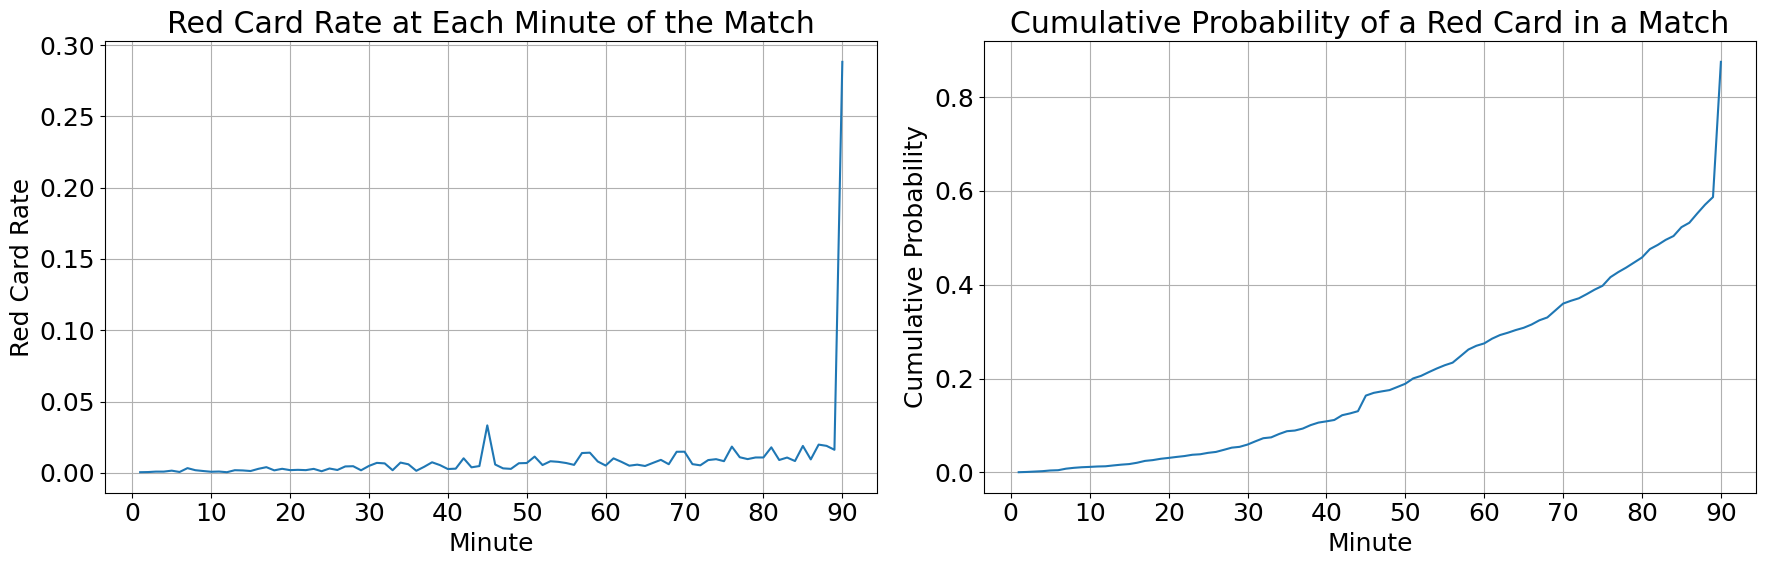

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Increase the size of the text in the plots
plt.rcParams['font.size'] = 18

# Calculate the total number of games
total_games = df['game_id'].nunique()

# Calculate the number of red cards given at each minute
red_cards_per_minute = df[df['type'] == 'red_card']['minute'].value_counts().sort_index()

# Calculate the red card rate at each minute
red_card_rate = red_cards_per_minute / total_games

# Calculate the cumulative number of red cards given up to each minute
cumulative_red_cards = np.cumsum(red_cards_per_minute)

# Calculate the cumulative probability of a red card
cumulative_probability = cumulative_red_cards / total_games

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the red card rate
axs[0].plot(red_card_rate.index, red_card_rate.values)
axs[0].set_title('Red Card Rate at Each Minute of the Match')
axs[0].set_xlabel('Minute')
axs[0].set_ylabel('Red Card Rate')
axs[0].set_xticks(range(0, 91, 10))
axs[0].grid(True)

# Plot the cumulative probability
axs[1].plot(cumulative_probability.index, cumulative_probability.values)
axs[1].set_title('Cumulative Probability of a Red Card in a Match')
axs[1].set_xlabel('Minute')
axs[1].set_ylabel('Cumulative Probability')
axs[1].set_xticks(range(0, 91, 10))
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


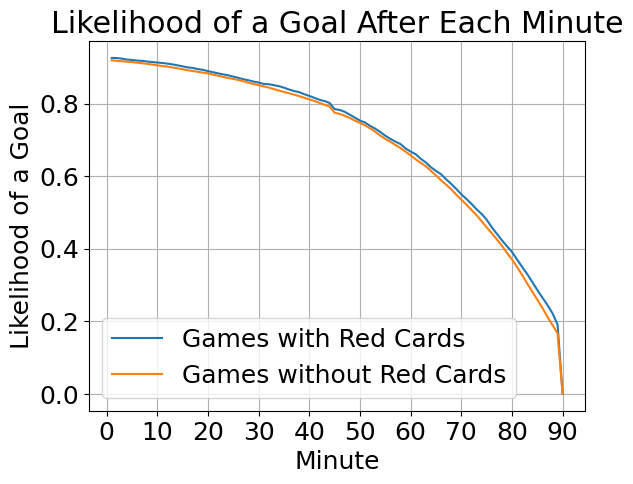

In [29]:
import matplotlib.pyplot as plt

# Identify unique game_ids with and without red cards
games_with_red_cards = df[df['type'] == 'red_card']['game_id'].unique()
games_without_red_cards = np.setdiff1d(df['game_id'].unique(), games_with_red_cards)

# Initialize lists to store the results
likelihoods_with_red_card = []
likelihoods_without_red_card = []

# Calculate the likelihood for each minute
for minute in range(1, 91):
    # Number of games with at least one goal after the current minute
    num_games_with_goal_with_red_card = df[(df['game_id'].isin(games_with_red_cards)) & (df['minute'] > minute) & (df['type'] == 'goal')]['game_id'].nunique()
    num_games_with_goal_without_red_card = df[(df['game_id'].isin(games_without_red_cards)) & (df['minute'] > minute) & (df['type'] == 'goal')]['game_id'].nunique()

    # Total number of games with and without a red card
    num_games_with_red_card = len(games_with_red_cards)
    num_games_without_red_card = len(games_without_red_cards)

    # Likelihood of a goal after the current minute
    likelihood_with_red_card = num_games_with_goal_with_red_card / num_games_with_red_card
    likelihood_without_red_card = num_games_with_goal_without_red_card / num_games_without_red_card

    likelihoods_with_red_card.append(likelihood_with_red_card)
    likelihoods_without_red_card.append(likelihood_without_red_card)

# Create the plot
fig, ax = plt.subplots()

# Plot the likelihoods
ax.plot(range(1, 91), likelihoods_with_red_card, label='Games with Red Cards')
ax.plot(range(1, 91), likelihoods_without_red_card, label='Games without Red Cards')

# Set the title and labels
ax.set_title('Likelihood of a Goal After Each Minute')
ax.set_xlabel('Minute')
ax.set_ylabel('Likelihood of a Goal')

# Set the x-axis ticks and grid
ax.set_xticks(range(0, 91, 10))
ax.grid(True)

# Add the legend
ax.legend()

# Show the plot
plt.show()


## 3.c: Rate of Scoring

In [30]:
# Sort the DataFrame
df = df.sort_values(['game_id', 'minute'])

# delete duplicate rows of games, as we only need info from one row
first_rows_df = df.drop_duplicates('game_id')

print('Mean goals per 10 minutes across all games:', round((first_rows_df.total_goals / 90).mean()*10, 4))

Mean goals per 10 minutes across all games: 0.2902


### Games with red cards:

In [31]:
# Sort the DataFrame
df_red_cards = df_red_cards.sort_values(['game_id', 'minute'])

# delete duplicate rows of games, as we only need info from one row
first_rows_reds = df_red_cards.drop_duplicates('game_id')

In [32]:
goals_per_minute_before_red = first_rows_reds.goals_before_first_red / first_rows_reds.red_card_minute
goals_per_minute_after_red = first_rows_reds.goals_after_first_red / (91 - first_rows_reds.red_card_minute)

print("Average goals per 10 minutes before red cards awarded:", round(goals_per_minute_before_red.mean()*10, 3))
print("Average goals per 10 minutes after red cards awarded:", round(goals_per_minute_after_red.mean()*10, 3))

Average goals per 10 minutes before red cards awarded: 0.243
Average goals per 10 minutes after red cards awarded: 0.762


### Games without Red Cards:

In [33]:
# Check rate for non-red games

# Sort the DataFrame
df_no_red_cards = df_no_red_cards.sort_values(['game_id', 'minute'])

# delete duplicate rows of games, as we only need info from one row
first_rows_no_reds = df_no_red_cards.drop_duplicates('game_id')

print('Mean goals per 10 minutes in games without red cards:', round((first_rows_no_reds.total_goals / 90).mean()*10, 4))

Mean goals per 10 minutes in games without red cards: 0.2901


## Split by competition:

In [34]:
# Group the data by 'competition' and calculate the mean goals per 90 minutes
mean_goals_per_90 = (first_rows_df.groupby('competition')['total_goals'].sum() / (90 * first_rows_df.groupby('competition').size())) * 10

# Print the result
for competition, mean_goals in mean_goals_per_90.items():
    print(f'Mean goals per 10 minutes in {competition} games without red cards:', round(mean_goals, 4))

# same as goals per game divided by 9

Mean goals per 10 minutes in 1. Bundesliga, Germany games without red cards: 0.3492
Mean goals per 10 minutes in 2. Bundesliga, Germany games without red cards: 0.3258
Mean goals per 10 minutes in Championship, England games without red cards: 0.279
Mean goals per 10 minutes in Ligue 1, France games without red cards: 0.2997
Mean goals per 10 minutes in Ligue 2, France games without red cards: 0.2561
Mean goals per 10 minutes in Premier League, England games without red cards: 0.3091
Mean goals per 10 minutes in Primera, Spain games without red cards: 0.2798
Mean goals per 10 minutes in Segunda, Spain games without red cards: 0.2449
Mean goals per 10 minutes in Serie A, Italy games without red cards: 0.3157
Mean goals per 10 minutes in Serie B, Italy games without red cards: 0.2737


In [35]:
# Define a function to calculate average goals per 10 minutes before and after red card
def calculate_average_goals(group):
    goals_per_minute_before_red = group['goals_before_first_red'] / group['red_card_minute']
    goals_per_minute_after_red = group['goals_after_first_red'] / (91 - group['red_card_minute'])
    return pd.Series({
        'average_goals_before_red': round(goals_per_minute_before_red.mean() * 10, 2),
        'average_goals_after_red': round(goals_per_minute_after_red.mean() * 10, 2)
    })

# Apply the function to each competition
average_goals = first_rows_reds.groupby('competition').apply(calculate_average_goals)

# Reset the index to turn 'competition' into a column
average_goals = average_goals.reset_index()

# Display the DataFrame
average_goals


/var/folders/m4/yvlz4y6d61zctf_c0kjjh05w0000gn/T/ipykernel_87721/2476130835.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_goals = first_rows_reds.groupby('competition').apply(calculate_average_goals)


,competition,average_goals_before_red,average_goals_after_red
0,"1. Bundesliga, Germany",0.30,0.76
1,"2. Bundesliga, Germany",0.26,0.96
2,"Championship, England",0.24,0.75
3,"Ligue 1, France",0.25,0.63
4,"Ligue 2, France",0.21,0.55
5,"Premier League, England",0.27,0.59
6,"Primera, Spain",0.26,0.71
7,"Segunda, Spain",0.20,0.72
8,"Serie A, Italy",0.28,1.06
9,"Serie B, Italy",0.23,0.89


In [36]:
# Calculate the difference
average_goals['difference'] = average_goals['average_goals_after_red'] - average_goals['average_goals_before_red']

# Display the DataFrame
average_goals

,competition,average_goals_before_red,average_goals_after_red,difference
0,"1. Bundesliga, Germany",0.30,0.76,0.46
1,"2. Bundesliga, Germany",0.26,0.96,0.70
2,"Championship, England",0.24,0.75,0.51
3,"Ligue 1, France",0.25,0.63,0.38
4,"Ligue 2, France",0.21,0.55,0.34
5,"Premier League, England",0.27,0.59,0.32
6,"Primera, Spain",0.26,0.71,0.45
7,"Segunda, Spain",0.20,0.72,0.52
8,"Serie A, Italy",0.28,1.06,0.78
9,"Serie B, Italy",0.23,0.89,0.66


In [37]:
# Filter rows where 'type' is 'red_card'
reds = df[df['type'] == 'red_card']

# Group the data by 'competition' and calculate the mean minute of red cards
average_minute = round(reds.groupby('competition')['minute'].mean(), 0)

# Convert the Series to a DataFrame and reset the index
average_minute = average_minute.reset_index()

# Rename the columns
average_minute.columns = ['competition', 'Average Minute of Red Cards']

# Display the DataFrame
average_minute

,competition,Average Minute of Red Cards
0,"1. Bundesliga, Germany",66.0
1,"2. Bundesliga, Germany",68.0
2,"Championship, England",72.0
3,"Ligue 1, France",74.0
4,"Ligue 2, France",63.0
5,"Premier League, England",60.0
6,"Primera, Spain",72.0
7,"Segunda, Spain",68.0
8,"Serie A, Italy",75.0
9,"Serie B, Italy",68.0


In [38]:
average_goals = average_goals.merge(average_minute, on='competition')
average_goals

,competition,average_goals_before_red,average_goals_after_red,difference,Average Minute of Red Cards
0,"1. Bundesliga, Germany",0.30,0.76,0.46,66.0
1,"2. Bundesliga, Germany",0.26,0.96,0.70,68.0
2,"Championship, England",0.24,0.75,0.51,72.0
3,"Ligue 1, France",0.25,0.63,0.38,74.0
4,"Ligue 2, France",0.21,0.55,0.34,63.0
5,"Premier League, England",0.27,0.59,0.32,60.0
6,"Primera, Spain",0.26,0.71,0.45,72.0
7,"Segunda, Spain",0.20,0.72,0.52,68.0
8,"Serie A, Italy",0.28,1.06,0.78,75.0
9,"Serie B, Italy",0.23,0.89,0.66,68.0


## 3.d: Sanctioned Team vs Opponents

In [39]:
# Create a new column 'red_card_team' to hold the team that got the red card
df_red_cards['red_card_team'] = df_red_cards[df_red_cards['type'] == 'red_card']['side']

# Forward fill the 'red_card_team' column to propagate the team that got the red card forward
df_red_cards['red_card_team'] = df_red_cards.groupby('game_id')['red_card_team'].ffill()

In [40]:
import pandas as pd
import numpy as np

# Assuming df_red_cards is your DataFrame

# Function to calculate goals after red card
def calculate_goals(group):
    # Find the first instance of red_card_team that isn't NaN
    red_card_team = group['red_card_team'].dropna().iloc[0]
    
    # Get the index of the first red card
    first_red_card_index = group['red_card_team'].first_valid_index()
    
    # Calculate the goals scored after the red card by the sanctioned team
    group['sanctioned_goals_after_red'] = group[(group.index > first_red_card_index) & (group['type'] == 'goal') & (group['side'] == red_card_team)]['type'].count()
    
    # Calculate the goals scored after the red card by the non sanctioned team
    group['non_sanctioned_goals_after_red'] = group[(group.index > first_red_card_index) & (group['type'] == 'goal') & (group['side'] != red_card_team)]['type'].count()
    
    return group

# Apply the function to each group
df_red_cards = df_red_cards.groupby('game_id').apply(calculate_goals, include_groups=False)

# Fill NaN values with 0
df_red_cards[['sanctioned_goals_after_red', 'non_sanctioned_goals_after_red']] = df_red_cards[['sanctioned_goals_after_red', 'non_sanctioned_goals_after_red']].fillna(0)

df_red_cards = df_red_cards.reset_index()
df_red_cards = df_red_cards.drop('level_1', axis=1)

In [41]:
# take first row to calculate only the goals once per game
first_row_reds_ = df_red_cards.drop_duplicates('game_id')

print("Average goals by sanctioned team after red card:", first_row_reds_.sanctioned_goals_after_red.mean())
print("Average goals by opposite team after red card:", first_row_reds_.non_sanctioned_goals_after_red.mean())


Average goals by sanctioned team after red card: 0.2632904308897594
Average goals by opposite team after red card: 0.7400671516508114


In [42]:
print("Rate of goals per 10 minutes after red card (sanctioned team):",round((first_row_reds_.sanctioned_goals_after_red/ (91 - first_row_reds_.red_card_minute)).mean()*10, 3))
print("Rate of goals per 10 minutes after red card (non-sanctioned team):",round((first_row_reds_.non_sanctioned_goals_after_red/ (91 - first_row_reds_.red_card_minute)).mean()*10, 3))

Rate of goals per 10 minutes after red card (sanctioned team): 0.208
Rate of goals per 10 minutes after red card (non-sanctioned team): 0.553


In [43]:
import pandas as pd

# Function to calculate rates
def calculate_rates(group):
    rate_sanctioned = round((group['sanctioned_goals_after_red'] / (91 - group['red_card_minute'])).mean() * 10, 3)
    rate_non_sanctioned = round((group['non_sanctioned_goals_after_red'] / (91 - group['red_card_minute'])).mean() * 10, 3)
    return pd.Series({'Rate_sanctioned': rate_sanctioned, 'Rate_non_sanctioned': rate_non_sanctioned})

# Apply the function to each group
rates = first_row_reds_.groupby('competition').apply(calculate_rates)

print(rates)


                         Rate_sanctioned  Rate_non_sanctioned
competition                                                  
1. Bundesliga, Germany             0.117                0.638
2. Bundesliga, Germany             0.212                0.752
Championship, England              0.399                0.347
Ligue 1, France                    0.123                0.510
Ligue 2, France                    0.150                0.404
Premier League, England            0.167                0.425
Primera, Spain                     0.194                0.518
Segunda, Spain                     0.159                0.560
Serie A, Italy                     0.295                0.765
Serie B, Italy                     0.260                0.630


/var/folders/m4/yvlz4y6d61zctf_c0kjjh05w0000gn/T/ipykernel_87721/1567312715.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = first_row_reds_.groupby('competition').apply(calculate_rates)


In [44]:
# Group by game_id and count the occurrences of 'red_card' in each group
red_card_counts = df[df['type'] == 'red_card'].groupby('game_id').size()

# Count the number of unique game_id rows with more than one 'red_card'
unique_game_ids_with_multiple_red_cards = (red_card_counts > 1).sum()

print("Number of unique game_id rows with more than one 'red_card':", unique_game_ids_with_multiple_red_cards)

Number of unique game_id rows with more than one 'red_card': 489


In [45]:
# games with 2 or more red card
print("Proportion of games with 2 or more red cards:", unique_game_ids_with_multiple_red_cards/len(df_g))

Proportion of games with 2 or more red cards: 0.025344666735772778


## 3.e: Goals shortly after red cards could be penalties (hence increased score)

In [46]:
# Sort again, see which games are featuring goals shortly after goals:
df_red_cards = df_red_cards.sort_values(['game_id', 'minute'])

# Define a function to check if a 'goal' occurred within 3 minutes after a 'red_card'
def has_goal_soon_after_red_card(group):
    red_cards = group[group['type'] == 'red_card']['minute']
    goals_after_red_card = group[(group['type'] == 'goal') & group['minute'].isin(pd.concat([red_cards, red_cards + 1, red_cards + 2, red_cards + 3]))]
    return len(goals_after_red_card) > 0

# Apply the function to each group
result = df_red_cards.groupby('game_id').apply(has_goal_soon_after_red_card,include_groups=False)

# Filter only the game_ids where the condition is True
game_ids_with_goal_shortly_after_red_card = result[result].index.tolist()

print("Game IDs with 'goal' after 'red_card' within 3 minutes:")
print(game_ids_with_goal_shortly_after_red_card)

Game IDs with 'goal' after 'red_card' within 3 minutes:
[84, 97, 225, 232, 242, 330, 339, 389, 461, 472, 579, 653, 658, 664, 733, 756, 785, 831, 895, 915, 972, 1005, 1129, 1138, 1144, 1152, 1173, 1183, 1210, 1211, 1224, 1230, 1269, 1270, 1273, 1334, 1402, 1420, 1437, 1438, 1443, 1475, 1532, 1533, 1539, 1579, 1580, 1586, 1590, 1609, 1614, 1625, 1633, 1652, 1840, 1845, 1906, 1913, 1947, 1949, 1955, 1993, 2062, 2131, 2177, 2195, 2217, 2239, 2244, 2271, 2286, 2374, 2386, 2389, 2412, 2416, 2441, 2476, 2494, 2503, 2513, 2598, 2732, 2733, 2785, 2806, 2825, 2853, 2873, 2900, 2904, 2933, 3015, 3079, 3081, 3144, 3149, 3150, 3207, 3278, 3282, 3325, 3387, 3396, 3451, 3463, 3468, 3493, 3520, 3540, 3604, 3609, 3618, 3644, 3660, 3672, 3701, 3827, 3850, 3893, 3924, 3970, 3988, 4062, 4094, 4110, 4111, 4136, 4200, 4212, 4244, 4249, 4250, 4255, 4315, 4367, 4368, 4371, 4385, 4429, 4507, 4517, 4546, 4573, 4585, 4600, 4627, 4671, 4701, 4709, 4769, 4813, 4847, 4931, 4952, 4986, 4987, 5034, 5046, 5124, 5163, 

In [47]:
# Group by game_id
grouped = df_red_cards.groupby('game_id')

# Define a function to count the number of times a 'goal' occurred within 3 minutes after a 'red_card'
def count_goal_shortly_after_red_card(group):
    red_cards = group[group['type'] == 'red_card']['minute']
    goals_after_red_card = group[(group['type'] == 'goal') & group['minute'].isin(pd.concat([red_cards, red_cards + 1, red_cards + 2, red_cards + 3]),)]
    return len(goals_after_red_card)

# Apply the function to each group
goal_counts_shortly_after_red_card = grouped.apply(count_goal_shortly_after_red_card,include_groups=False)

print("Number of times 'goal' occurred within 3 minutes after 'red_card' in each game:")
print(goal_counts_shortly_after_red_card.sum())

Number of times 'goal' occurred within 3 minutes after 'red_card' in each game:
626


In [48]:
# how many goals after red cards were within 3 mins
print("% of goals within 3 minutes of red cards:")
print(round((goal_counts_shortly_after_red_card.sum()/first_rows_reds.goals_after_first_red.sum())*100, 2))

% of goals within 3 minutes of red cards:
17.46


In [49]:
# Group by game_id
grouped = df.groupby('game_id')

# List to store minutes difference between red card and subsequent goals
minutes_difference_list = []

# Iterate over groups
for name, group in grouped:
    red_card_index = group[group['type'] == 'red_card'].index
    if not red_card_index.empty:
        red_card_minute = group.loc[red_card_index[0], 'minute']
        goals_after_red_card = group[(group['type'] == 'goal') & (group['minute'] > red_card_minute)]
        if not goals_after_red_card.empty:
            minutes_difference = goals_after_red_card['minute'].min() - red_card_minute
            minutes_difference_list.append(minutes_difference)

# Convert list to DataFrame
minutes_difference_df = pd.DataFrame({'minutes_difference': minutes_difference_list})


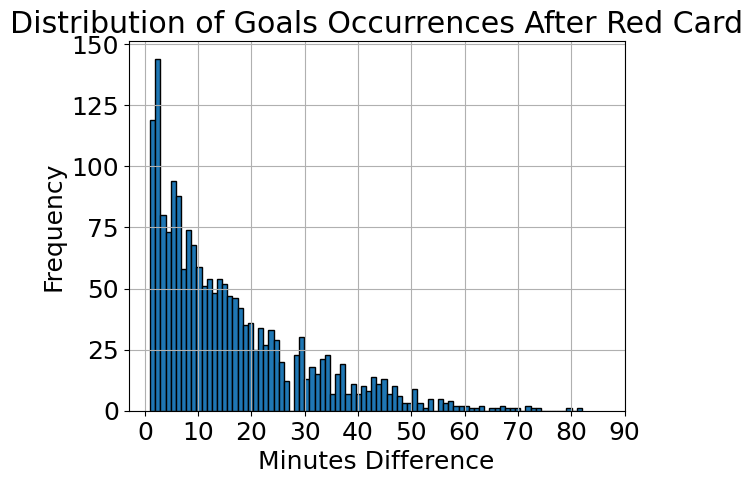

In [50]:
# Plot distribution graph
ax = minutes_difference_df.hist(bins=84, edgecolor='black')
ax[0][0].set_xlabel('Minutes Difference')
ax[0][0].set_ylabel('Frequency')
ax[0][0].set_title('Distribution of Goals Occurrences After Red Card')
ax[0][0].set_xticks(range(0, 91, 10))
plt.show()